# Color Deconvolution

Color deconvolution uses color profiles of stains like hematoxylin or diaminobenzidine to digitally separate stains from a color image. This step can help to isolate components like nuclei or positive staining structures which can improve quantitation or other image analysis tasks like segmentation. These examples illustrate how to use HistomicsTK to perform color deconvolution with either known static or adaptive color profiles.

In [1]:
from __future__ import print_function

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

## Load input image

HistomicsTK's color deconvolution routines operate on RGB images,
represented as either `NxMx3` or `3xN` arrays of Numpy's `ndarray` type.

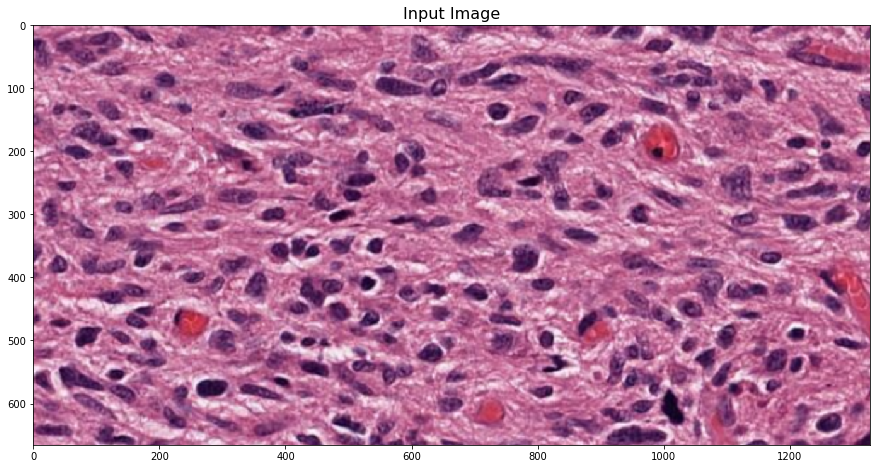

In [2]:
inputImageFile = ('https://data.kitware.com/api/v1/file/'
                  '57802ac38d777f12682731a2/download')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

## Supervised color deconvolution with a known stain matrix

If you know what the stain matrix to be used for color deconvolution is,
computing the deconvolved image is as simple as calling the `color_deconvolution` function
in `histomicstk.preprocessing.color_deconvolution`.  Its input is an RGB image and
the stain matrix, and its output is a `namedtuple` with fields
`Stains`, `StainsFloat`, and `Wc`.

Here, we use the built-in `stain_color_map` dictionary for reference values
to fill in the stain matrix.  If the image is only two-stain, it makes sense
to set the third stain vector perpendicular to the other two, and `color_deconvolution`
does this automatically if the third column is all 0.

stain_color_map:
{'eosin': [0.07, 0.99, 0.11], 'null': [0.0, 0.0, 0.0], 'hematoxylin': [0.65, 0.7, 0.29], 'dab': [0.27, 0.57, 0.78]}


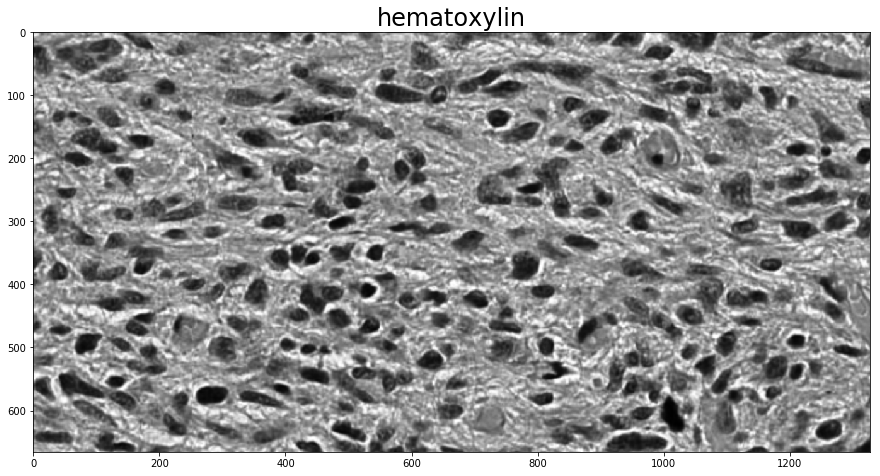

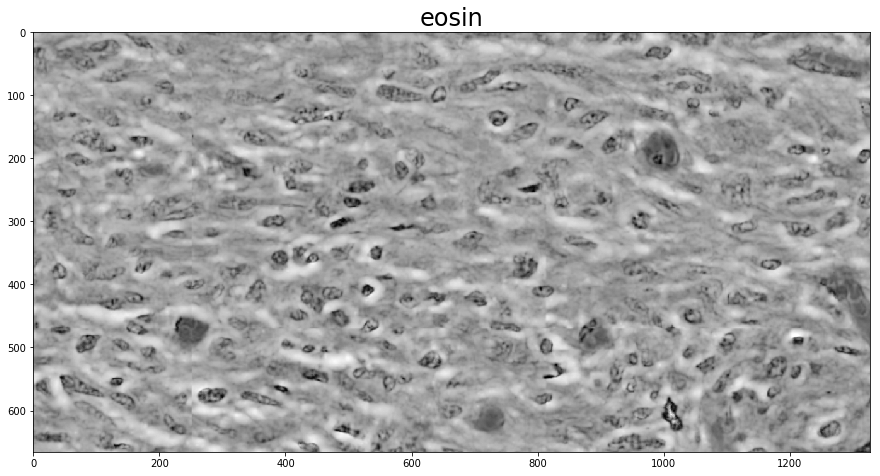

In [3]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

## Unsupervised color deconvolution
### Sparse non-negative matrix factorization

To determine the stain vectors (somewhat) automatically,
HistomicsTK has a couple different methods.  The first employs
*S*parse *N*on-negative *M*atrix *F*actorization (SNMF) to estimate the stain vectors
based on an initial guess.  Using these methods for color deconvolution
then requires two steps, one to calculate the stain vectors with one of the
`(rgb_)separate_stains_*` functions in `histomicstk.preprocessing.color_deconvolution`
and another to apply them to the image with `color_deconvolution`.

This example also makes direct use of one of the non-`rgb_`-prefixed
stain-separation functions, which expect an image in the logarithmic SDA space.
The conversion to SDA space is done with the `rgb_to_sda` function in
`histomicstk.preprocessing.color_conversion`.  The RGB-to-SDA conversion is
parameterized by the background intensity of the image, here called `I_0`,
which we set to 255 (full white; as a scalar it is applied across all channels)
as there is no background in the image.  With background available, the function
`background_intensity` in `histomicstk.preprocessing.color_normalization`
can be used to estimate it.

Estimated stain colors (in rows):
[[ 0.48031803  0.78512115  0.39099791]
 [ 0.18892848  0.81830444  0.54284792]]


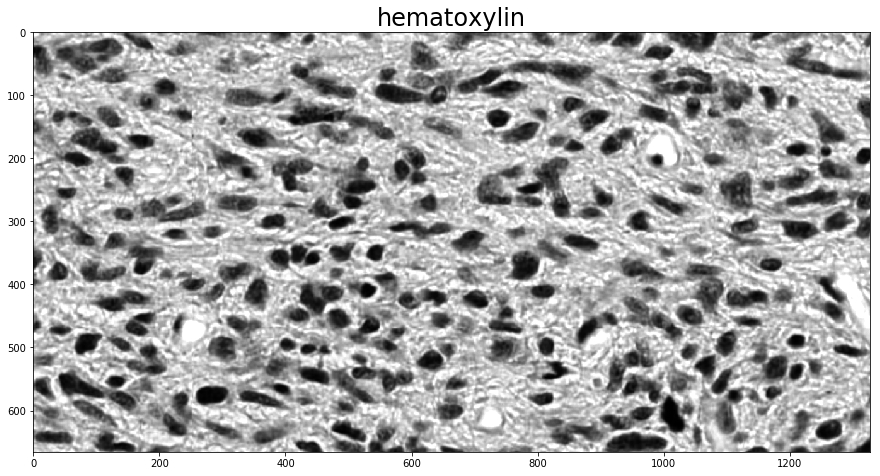

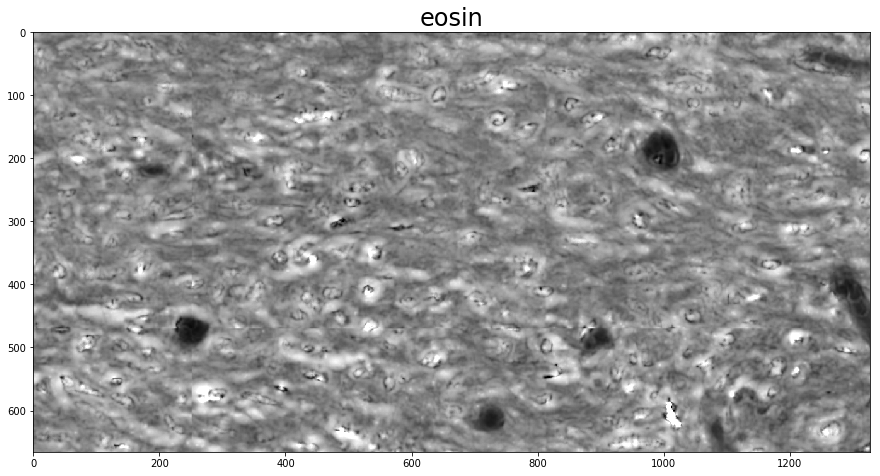

In [4]:
# create initial stain matrix
W_init = W[:, :2]

# Compute stain matrix adaptively
sparsity_factor = 0.5

I_0 = 255
im_sda = htk.preprocessing.color_conversion.rgb_to_sda(imInput, I_0)
W_est = htk.preprocessing.color_deconvolution.separate_stains_xu_snmf(
    im_sda, W_init, sparsity_factor,
)

# perform sparse color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(
    imInput, 
    htk.preprocessing.color_deconvolution.complement_stain_matrix(W_est),
    I_0,
)

print('Estimated stain colors (in rows):', W_est.T, sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

### The PCA-based method of Macenko et al.

Using the `rgb_separate_stains_*` functions is much the same,
except the conversion to SDA space is done as part of the call.
The PCA-based routine, unlike the SNMF-based one, does not require an initial guess,
and instead automatically determines the vectors of a two-stain image.
Because this determination is fully automatic, the order of
the stain vector columns in the output is arbitrary.  In order to determine which is which,
a `find_stain_index` function is provided in `histomicstk.preprocessing.color_deconvolution`
that identifies the column in the color deconvolution matrix
closest to a given reference vector.

Estimated stain colors (rows):
[[ 0.16235564  0.81736416  0.55277164]
 [ 0.46329113  0.78963352  0.40229373]]


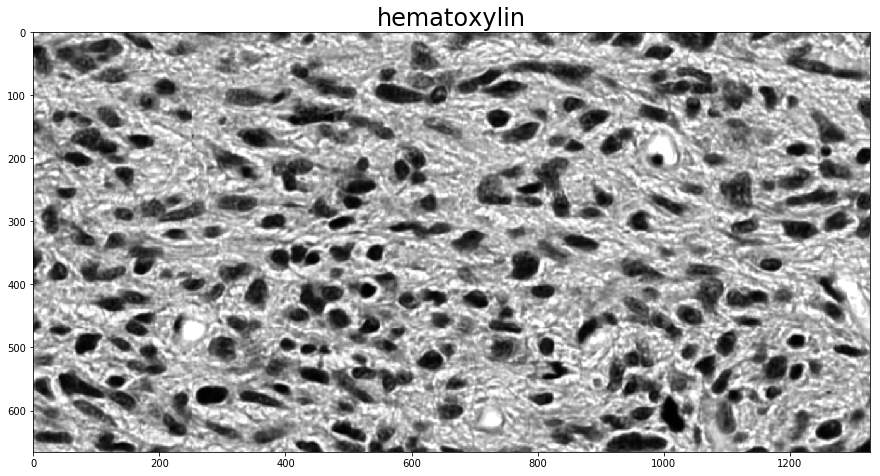

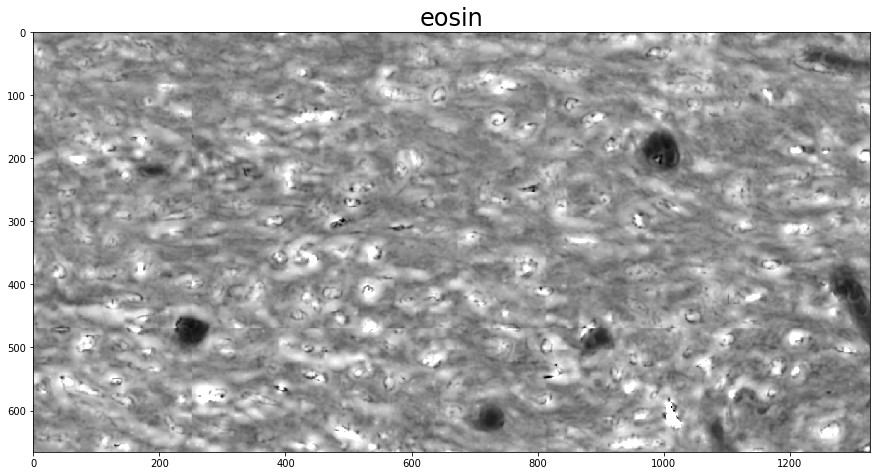

In [5]:
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)

# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)